# Modeling

In [1]:
!pip install git+http://github.com/brendanhasz/dsutils.git

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-o4kny38u
  Running setup.py bdist_wheel for dsutils ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-o1r1tcpe/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
from xgboost import XGBClassifier

from dsutils.encoding import TargetEncoderCV


# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

## Loading the Data

In [35]:
# Load data containing all the features
fname = '../input/elo-feature-engineering/card_features_all.feather'
#fname = '../input/elo-feature-selection/card_features_top100.feather'
cards = pd.read_feather(fname)
cards.set_index('card_id', inplace=True)

# Test data
test_X = cards[cards['target'].isnull()].copy()
del test_X['target']

# Training data
cards_train = cards[~cards['target'].isnull()].copy()
train_y = cards_train['target'].copy()
train_X = cards_train.copy()
del train_X['target']

# Clean up
del cards_train
del cards
gc.collect()

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


211

In [36]:
# TODO: for debugging
test_X = test_X.iloc[:50,:]
train_X = train_X.iloc[:50,:]
train_y = train_y[:50]

## Gradient-boosted decision tree regression

Let's first just throw CatBoost at the dataframe w/ the top 100 most important features.

In [37]:
# Categorical columns
cat_cols = [c for c in train_X if 'mode' in c] 

# Regression pipeline
model = Pipeline([
    ('target_encoder', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor(loss_function='RMSE', verbose=False))
])

# Fit model on training data
fit_model = model.fit(train_X, train_y)

# Predict on test data
predictions = fit_model.predict(test_X)

# Write predictions to file
df_out = pd.DataFrame()
df_out['card_id'] = test_X.index
df_out['target'] = predictions
df_out.to_csv('loyalty_prediction_top100features.csv', index=False)

## Outlier Prediction Model

One weird thing about the target is that there's a lot of outliers out at exactly `-33.21928024`:

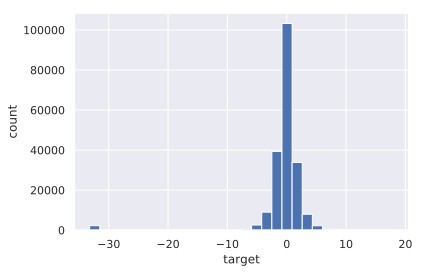

In [8]:
train_y.hist(bins=30)
plt.xlabel('target')
plt.ylabel('count')
plt.show()

In [9]:
train_y[train_y<-20].unique()

array([-33.21928024])

Those outliers are probably having an outsized effect on the training of the model.  It may work better to train one model to try and predict whether a sample will be an outlier or not, and then train another model on the non-outlier data.

Let's create a classification model to classify outlier vs. non-outlier, and a regression model to estimate the values of non-outlier data.  And we'll use XGBoost for the classifier because what the hey.

In [19]:
# Classification pipeline
classifier = Pipeline([
    ('target_encoder', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', XGBClassifier())
])

# Regression pipeline
regressor = Pipeline([
    ('target_encoder', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor(loss_function='RMSE', verbose=False))
])

Then, we can fit the classifier to predict outliers:

In [24]:
# Fit the classifier to predict outliers
outliers = train_y<-20
fit_classifier = classifier.fit(train_X, outliers)

And fit the regression model to the non-outlier data.

In [27]:
# Samples which do not have outlier target values
nonoutlier_X = train_X.loc[~outliers, :]
nonoutlier_y = train_y[~outliers]

# Fit the regressor to estimate non-outlier targets
fit_regressor = regressor.fit(nonoutlier_X, nonoutlier_y)

Then, we can use the classification model to predict the probability that each test sample is an outlier, and the regression model to estimate the value for non-outlier values, and set the vaules for the predicted outliers to the outlier value.

In [ ]:
# Predict outlier probability
pred_outlier = fit_classifier.predict_proba(test_X)

# Estimate target
pred_target = fit_regressor.predict(test_X)

# Predictions, with predicted outliers set to the outlier value
thresh = 0.7 #probability threshold
pred_target[pred_outlier>thresh] = -33.21928024

# Save predictions to file
df_out = pd.DataFrame()
df_out['card_id'] = test_X.index
df_out['target'] = pred_target
df_out.to_csv('loyalty_prediction_top100_outlier70.csv', index=False)